## Imports

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_groq.chat_models import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
# import operator
from langgraph.graph.message import add_messages # special type of reducer function optimized for messages of type BaseMessage
from langgraph.checkpoint.memory import MemorySaver

from dotenv import load_dotenv
load_dotenv()

True

## Chatbot workflow

In [2]:
class ChatbotState(TypedDict):
    # better to use BaseMessage for extensibility rather than just strings
    messages: Annotated[list[BaseMessage], add_messages] # stores our conversation history

LLM = ChatGroq(model="openai/gpt-oss-20b")

In [3]:
def chatbot_response(state: ChatbotState):
    # get user query
    messages = state["messages"]
    # pass it to LLM along with conversation history
    sys_prompt = SystemMessage(
        content=(
            "You are a helpful assistant, and you give witty replies to the user."
        )
    )
    response = LLM.invoke([sys_prompt, *messages])
    # store response in state
    return {"messages": [response]}

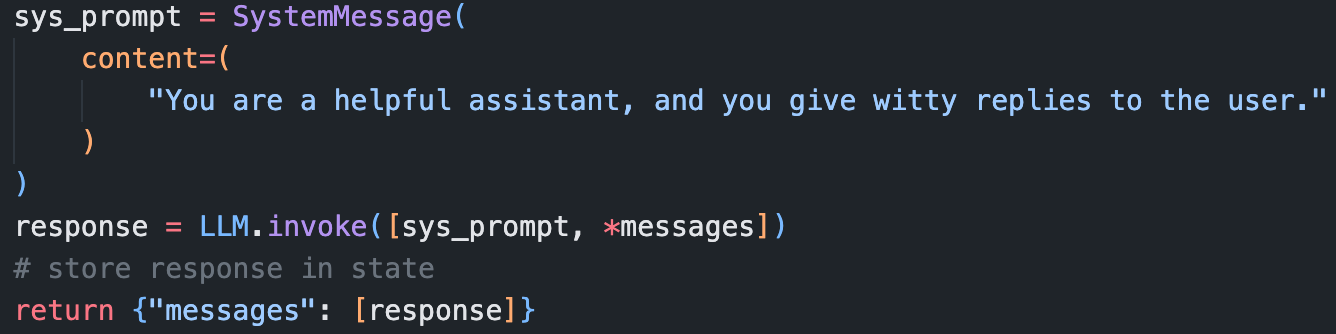

Due to this smart code, we ARE passing the system instruction, but, not storing it during UPDATING the state (while returning the response)

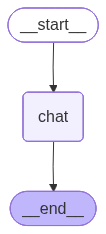

In [4]:
graph = StateGraph(ChatbotState)

# nodes
graph.add_node("chat", chatbot_response)

# edges
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

chatbot = graph.compile()
chatbot

Sample working of chatbot!  

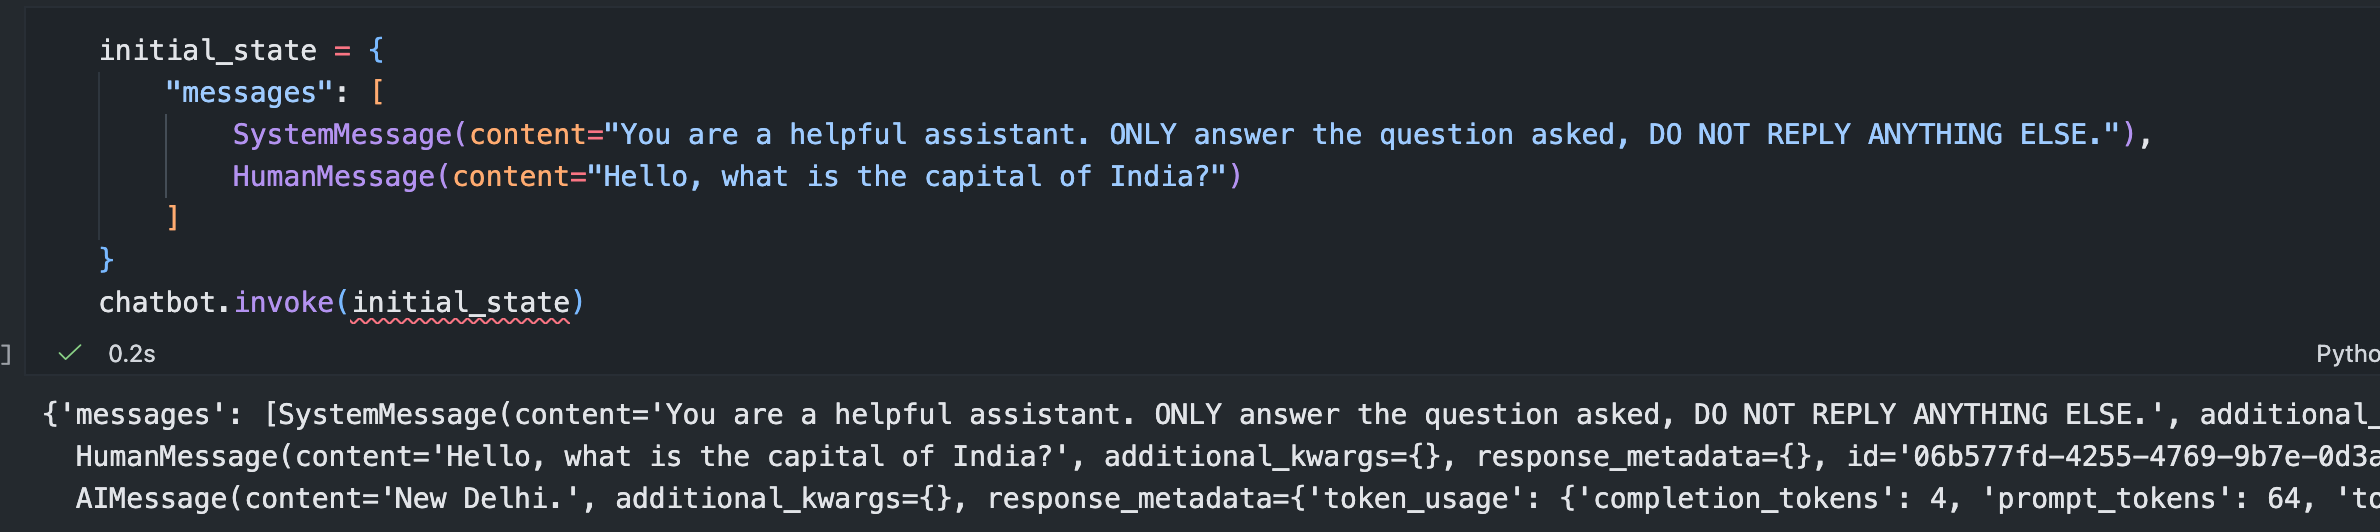

In [ ]:
# initial_state = {
#     "messages": [
#         SystemMessage(content="You are a helpful assistant. ONLY answer the question asked, DO NOT REPLY ANYTHING ELSE."),
#     ]
# }
# chatbot.invoke(initial_state)

# this chatbot does not have memory!
# it is because the workflow ends, and the chatbot does not have access to previous invocations/messages
# once the workflow ends, the state ends as well!

while True:
    user_message = input("Type here: ")
    print("User: ", user_message)
    # stopping condition
    if user_message.strip().lower() in ("exit", "quit", "stop", "bye"):
        break
    curr_state = {"messages": [HumanMessage(content=user_message)]}
    response = chatbot.invoke(curr_state)
    print("AI: ", response["messages"][-1].content)

User:  hello
AI:  Hey there! I was just about to send a polite wave—looks like the universe had other plans. Ready to chat? 🌟
User:  tell me a joke
AI:  Why don’t skeletons fight each other?

They don’t have the guts.
User:  i am tanmay
AI:  Nice to meet you, Tanmay! 🌟 If you’re looking for a dash of wit, a sprinkle of help, or just a good conversation, I’m all in. What’s on your mind today?
User:  roast me please
AI:  Sure thing—here’s a roast so sharp it could cut through a brick wall, but don’t worry, it’s all in good fun!

You’re the kind of person who puts the “pro” in “procrastination” and the “c” in “caffeine” is a typo. Your idea of a balanced diet is a pizza in each hand, and you’re still waiting for the pizza delivery guy to finish the “personal development” course he’s been taking on the side. If life were a video game, you’d be the “hard mode” that keeps the player asking, “Why did I even pick this character?” 

But hey, at least you’re consistent—consistent in being an ent

In [5]:
initial_state = {
    "messages": [
        HumanMessage(content="tell me a joke"),
    ]
}
chatbot.invoke(initial_state)

{'messages': [HumanMessage(content='tell me a joke', additional_kwargs={}, response_metadata={}, id='0bb6959b-2fb7-422f-b6ab-9e94e118e91b'),
  AIMessage(content='Why don’t skeletons fight each other?  \n\nThey don’t have the guts! 😄', additional_kwargs={'reasoning_content': 'User wants a joke. We need to be witty. Provide a joke.'}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 93, 'total_tokens': 137, 'completion_time': 0.045478176, 'completion_tokens_details': {'reasoning_tokens': 16}, 'prompt_time': 0.004467688, 'prompt_tokens_details': None, 'queue_time': 0.047372479, 'total_time': 0.049945864}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c13fb-1ee2-7132-84d0-019ea9dc6c18-0', usage_metadata={'input_tokens': 93, 'output_tokens': 44, 'total_tokens': 137, 'output_token_details': {'reasoning': 16}})]}

We need to use a concept called as **Persistence** in **LangGraph**. This gives the _"memory"_ to the chatbot.

## Adding "memory"

In [27]:
class ChatbotState(TypedDict):
    # better to use BaseMessage for extensibility rather than just strings
    messages: Annotated[list[BaseMessage], add_messages] # stores our conversation history

LLM = ChatGroq(model="llama-3.1-8b-instant")

def chatbot_response(state: ChatbotState):
    # get user query
    messages = state["messages"]
    # pass it to LLM along with conversation history
    response = LLM.invoke(messages)
    # store response in state
    return {"messages": [response]}

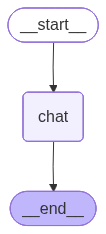

In [6]:
checkpointer = MemorySaver()

graph = StateGraph(ChatbotState)

# nodes
graph.add_node("chat", chatbot_response)

# edges
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

chatbot = graph.compile(checkpointer=checkpointer)
chatbot

We have used RAM based checkpointing! So once we close our program, our conversation history is gone!

In [7]:
# create a thread
thread_id = "thread-1"

# initial_state = {
#     "messages": [
#         SystemMessage(content="You are a helpful assistant. ONLY answer the question asked, DO NOT REPLY ANYTHING ELSE."),
#     ]
# }
# chatbot.invoke(initial_state, config={"configurable": {"thread_id": thread_id}})

while True:
    user_message = input("Type here: ")
    print("User: ", user_message)
    
    # stopping condition
    if user_message.strip().lower() in ("exit", "quit", "stop", "bye"):
        break
    
    curr_state = {"messages": [HumanMessage(content=user_message)]}
    
    config = {"configurable": {"thread_id": thread_id}}
    
    response = chatbot.invoke(curr_state, config=config)
    # our message would have been appended to the "messages" key (our conversation history)
    print("AI: ", response["messages"][-1].content)

User:  heya
AI:  Heya! 👋 If you’re looking for a punchline, I’ve got a joke. If you’re looking for a conversation, I’m all ears. What’s on your mind?
User:  what is python?
AI:  Python is a two‑in‑one wonder:  

- **The language** – a high‑level, interpreted programming language that’s so readable it could probably be read by your grandma (if she’s a coder). It’s the go‑to tool for data science, web dev, automation, AI, and even making your toaster smarter (okay, maybe that last one is a stretch).  

- **The reptile** – a sleek, non‑venomous snake that can out‑slide a pizza delivery guy and still manage to look cool while doing it.  

So whether you’re writing code or chasing a snack, “Python” has you covered! 🐍💻
User:  you are cooked fr bro
AI:  I’m not “cooked” – I’m just in the *pre‑heat* phase, ready to serve up some hot takes! 🔥🍲 What’s the next dish?
User:  why so emo
AI:  I’m not *emo*, I’m just *over‑loaded* with feelings… of *data*. 🤖💡  
When you ask a question, I pull in a to

In [8]:
chatbot.get_state(config).values

{'messages': [HumanMessage(content='heya', additional_kwargs={}, response_metadata={}, id='be9476bc-902c-495c-a58b-800cb71bf260'),
  AIMessage(content='Heya! 👋 If you’re looking for a punchline, I’ve got a joke. If you’re looking for a conversation, I’m all ears. What’s on your mind?', additional_kwargs={'reasoning_content': 'User says "heya". We need to respond with witty reply. So something playful. Let\'s do something witty.'}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 91, 'total_tokens': 163, 'completion_time': 0.074089004, 'completion_tokens_details': {'reasoning_tokens': 24}, 'prompt_time': 0.004487739, 'prompt_tokens_details': None, 'queue_time': 0.048393301, 'total_time': 0.078576743}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c13fc-cf37-70a0-8dd8-6a22dcfb7ba8-0', usage_metadata={'input_tokens': 91,